# Example problems in CVXPY

In [294]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

## Dynamic pricing

### Exponential demand

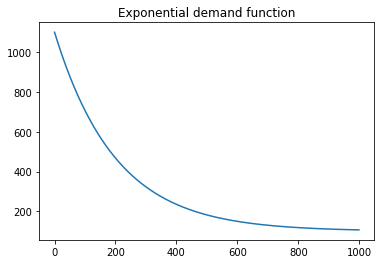

In [319]:
a = 1000
b = 0.005

rates = np.arange(0,1000)
demands = [(a*cp.exp(-b*rate) + c).value for rate in rates]
plt.plot(rates,demands)
plt.title('Exponential demand function')
plt.show()

/var/folders/zy/v62jc4q53tb9fs6jc0qpwrtm0000gn/T/ipykernel_54313/1712810625.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
/var/folders/zy/v62jc4q53tb9fs6jc0qpwrtm0000gn/T/ipykernel_54313/1712810625.py:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x)


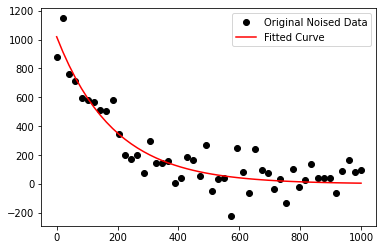

Actual parameters: [1000, 0.005]
Fitted parameters: [1.01959408e+03 5.31296969e-03]


In [309]:
def function_to_fit(x, a, b):
    return a * np.exp(-b * x)

alpha = 1000
beta = 0.005

X = np.linspace(0, 1000, 50)
Y = function_to_fit(X, alpha, beta)
Yn = Y + 100*np.random.normal(size=len(X))

popt, pcov = curve_fit(function_to_fit, X, Yn)

plt.figure()
plt.plot(X, Yn, 'ko', label="Original Noised Data")
plt.plot(X, function_to_fit(X, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

margin = 400 * beta
print('Actual parameters:', [alpha, beta])
print('Fitted parameters:', popt)

### How can we maximize the revenue function with CVXPY?

> https://www.cvxpy.org/tutorial/dcp/index.html

Need ideas

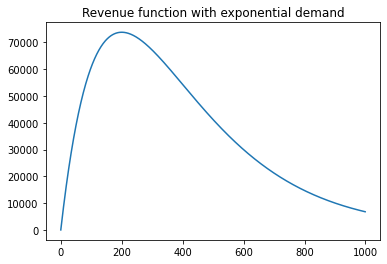

In [316]:
a = 1000
b = 0.005
c = 100
X = np.arange(0,1000)
y = [(x * a * cp.exp(-b * x) + c).value for x in X]
plt.plot(X,y)
plt.title('Revenue function with exponential demand')
plt.show()

In [299]:
x = cp.Variable()
revenue = x*(a*cp.exp(-b*x))
prob = cp.Problem(cp.Maximize(revenue))
#prob.solve(solver='ECOS_BB')  # throws DCP error 

### Linear demand

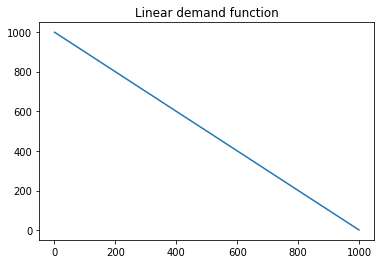

In [317]:
a = 1
b = 1000
X = np.arange(1,1000)
y = [(-a*x + b) for x in X]
plt.plot(X,y)
plt.title('Linear demand function')
plt.show()

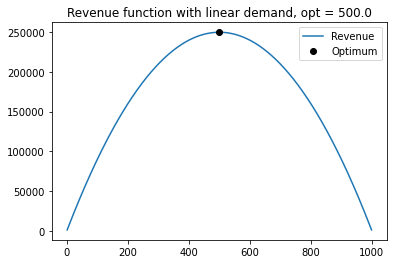

In [318]:
# Revenue curve
a = 1
b = 1000
X = np.arange(1,1000)
y = [x*(-a*x + b) for x in X]
plt.plot(X,y, label='Revenue')

# Optimum rate
rate = cp.Variable()
revenue = -a*cp.power(rate,2) + b*rate
prob = cp.Problem(cp.Maximize(revenue))
opt_revenue = prob.solve()
opt_rate = rate.value
plt.plot(opt_rate, opt_revenue, 'ko', label='Optimum')

# Finalise plot
plt.title(f'Revenue function with linear demand, opt = {opt_rate}')
plt.legend()
plt.show()

### Multiple linear demands

In [180]:
n_demands = 3
# Model linear demands
a = -(np.ones(n_demands))
b = np.ones(n_demands) * 1000
rate = cp.Variable(n_demands)
#demand = cp.sum(cp.multiply(a, rate) + b)
revenue = cp.sum(a@cp.power(rate,2) + b@rate)
prob = cp.Problem(cp.Maximize(revenue))
opt_revenue = prob.solve()
opt_rate = rate.value
print(opt_revenue, opt_rate)

750000.0 [500. 500. 500.]


## Capacity-constrained dynamic pricing

In [325]:
np.random.seed(1)
n_demands = 20
n_resources = 10

# Decision variable
rate = cp.Variable(n_demands)

# Linear demand parameters
alpha = -(np.ones(n_demands))
beta = np.ones(n_demands) * 1000
demand = cp.multiply(alpha, rate) + beta

# objective function
revenue = cp.sum(alpha@cp.power(rate,2) + beta@rate) # manually multiplied demand and rate
#revenue = rate@demand  # doesn't work, but why?

# capacity constraint
capacity = np.ones(n_resources) * 2000
uses = np.random.choice(a=[False, True], size=(n_resources, n_demands)).astype(int)
cap_constraint = uses@demand <= capacity

prob = cp.Problem(cp.Maximize(revenue), [cap_constraint])
opt_revenue = prob.solve()
opt_rate = rate.value
print(opt_revenue.round(), opt_rate.round())

2880282.0 [880. 880. 880. 972. 972. 836. 771. 836. 745. 815. 680. 745. 680. 815.
 880. 701. 836. 771. 836. 771.]


## Least-squares

In [58]:
# Import packages.
import cvxpy as cp
import numpy as np

# Generate data.
m = 10 # total number of observations
n = 3  # dimensionality of X
np.random.seed(1)
A = np.random.randn(m, n) # observed X
b = np.random.randn(m) # observed y

# Define and solve the CVXPY problem.
x = cp.Variable(n)  # parameters we want to find
cost = cp.sum_squares(A @ x - b)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

# Print result.
print("\nThe minimum error is", prob.value)
print("The optimal parameter values are")
print(x.value)
print("The L2 norm of the residual is ", cp.norm(A @ x - b, p=2).value)


The minimum error is 5.558922462953001
The optimal parameter values are
[-0.15495795 -0.2622656   0.19315605]
The L2 norm of the residual is  2.3577367246902274


## Linear program

In [29]:
# Generate a random non-trivial linear program.
m = 15
n = 10
np.random.seed(1)
s0 = np.random.randn(m)
lamb0 = np.maximum(-s0, 0)
s0 = np.maximum(s0, 0)
x0 = np.random.randn(n)
A = np.random.randn(m, n)
b = A @ x0 + s0
c = -A.T @ lamb0

# Define and solve the CVXPY problem.
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize(c.T@x),
                 [A @ x <= b])
prob.solve(solver='ECOS_BB')
#prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution is")
print(prob.constraints[0].dual_value)


The optimal value is -15.220912605552863
A solution x is
[-1.10133381 -0.16360111 -0.89734939  0.03216603  0.6069123  -1.12687348
  1.12967856  0.88176638  0.49075229  0.8984822 ]
A dual solution is
[6.98805172e-10 6.11756416e-01 5.28171747e-01 1.07296862e+00
 3.93759300e-09 2.30153870e+00 4.25704434e-10 7.61206896e-01
 8.36906030e-09 2.49370377e-01 1.30187120e-09 2.06014070e+00
 3.22417207e-01 3.84054343e-01 1.59493839e-09]


# Mixed-integer quadratic program

In [17]:
# Generate a random problem
np.random.seed(0)
m, n= 40, 25

A = np.random.rand(m, n)
b = np.random.randn(m)

# Construct a CVXPY problem
x = cp.Variable(n, integer=True)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
prob = cp.Problem(objective)
prob.solve(solver='ECOS_BB')

13.660003257752997